(1279, 1706, 3)
(1279, 1706, 3)


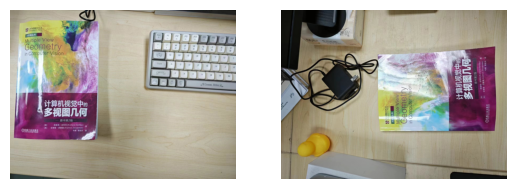

In [74]:
import cv2 as cv
import matplotlib.pyplot as plt

img1 = cv.imread('img1.jpg')
img2 = cv.imread('img2.jpg')
print(img1.shape)
print(img2.shape)

def show_imgs(img1, img2):
    plt.subplot(1, 2, 1)
    plt.imshow(img1[:, :, ::-1])
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(img2[:, :, ::-1])
    plt.axis('off')
show_imgs(img1, img2)

3734 4046


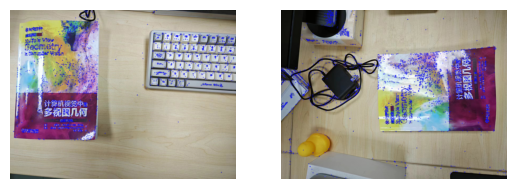

In [75]:
# 求SIFT关键点
sift = cv.SIFT_create()

keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)
print(len(keypoints1), len(keypoints2))

image_with_keypoints1 = cv.drawKeypoints(img1, keypoints1, None, (255, 0, 0))
image_with_keypoints2 = cv.drawKeypoints(img2, keypoints2, None, (255, 0, 0))
show_imgs(image_with_keypoints1, image_with_keypoints2)

(-0.5, 3411.5, 1278.5, -0.5)

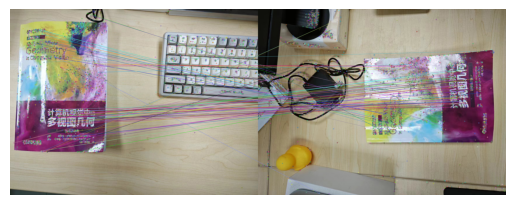

In [100]:
# 匹配关键点
matcher = cv.BFMatcher()
matches = matcher.knnMatch(descriptors1, descriptors2, k=1)  # 每个元素是一个tuple, 长度为k


from itertools import chain
matches = list(chain.from_iterable(matches))
K = 100
good_matches = sorted(matches, key=lambda x: x.distance)[:K]

result = cv.drawMatches(img1, keypoints1, img2, keypoints2, good_matches, None)
plt.imshow(result[:, :, ::-1])
plt.axis('off')

(100, 2) (100, 2)
(3, 3)
(100, 1)
1701 1402


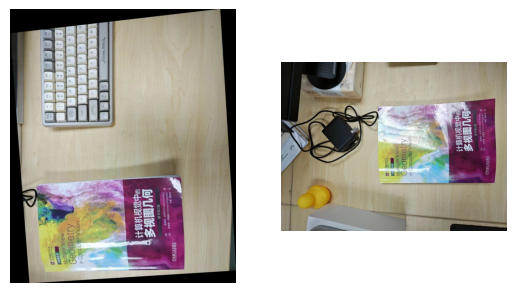

In [101]:
# 求射影变换
import numpy as np
points1 = np.array([keypoints1[m.queryIdx].pt for m in good_matches])
points2 = np.array([keypoints2[m.trainIdx].pt for m in good_matches])
print(points1.shape, points2.shape)

homography, mask = cv.findHomography(points1, points2, cv.RANSAC, 2)
print(homography.shape)
print(mask.shape)  # 一个一维的mask，指出哪些点是外点（0是外点，1是内点）

# 计算映射之后，像素点出现的范围，确定目标图像的大小
h, w, c = img1.shape
corner_points = np.array([
    [0, w-1, 0, w-1],
    [0, 0, h-1, h-1],
    [1, 1, 1, 1]
])
transformed_points = np.matmul(homography, corner_points)  # 3 * 4

# 添加平移矩阵，把坐标都平移到正的
transformed_points /= transformed_points[2:, :]  # 齐次空间到像素空间
min_x, max_x = transformed_points[0].min(), transformed_points[0].max()
min_y, max_y = transformed_points[1].min(), transformed_points[1].max()
min_x, max_x = int(min_x), int(max_x)
min_y, max_y = int(min_y), int(max_y)
translation_matrix = np.array([[1, 0, -min_x], [0, 1, -min_y], [0, 0, 1]], dtype=np.float32)

# 确定图像范围
target_h, target_w = max_y - min_y, max_x - min_x
print(target_h, target_w)
img1_ = cv.warpPerspective(img1, np.matmul(translation_matrix, homography), (target_w, target_h))
show_imgs(img1_, img2)

(-0.5, 1947.5, 2016.5, -0.5)

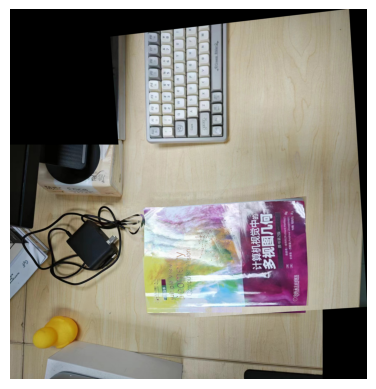

In [102]:
# 将变换后的图像拼接
min_x = min(min_x, 0)
max_x = max(max_x, w-1)
min_y = min(min_y, 0)
max_y = max(max_y, h-1)
translation_matrix = np.array([[1, 0, -min_x], [0, 1, -min_y], [0, 0, 1]], dtype=np.float32)
target_w, target_h = max_x - min_x, max_y - min_y
img1_ = cv.warpPerspective(img1, np.matmul(translation_matrix, homography), (target_w, target_h))
img2_ = cv.warpPerspective(img2, translation_matrix, (target_w, target_h))
img_fusion = np.maximum(img1_, img2_)  # 取平均不行，会把不重叠的部分变灰。这里取max也不好，高光不合理。更好的做法是用图像金字塔融合
plt.imshow(img_fusion[:, :, ::-1])
plt.axis('off')